# Imports and Global Variables

In [1]:
import os
os.chdir('/Users/gil2rok/school/crispr-phylogeny2/code/Heracles')

import pickle
import torch
import geoopt
import icecream as ic
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

from mlflow import log_metric
from scipy.linalg import expm
from scipy.cluster.hierarchy import average, to_tree
import icecream as ic

from metrics import pairwise_dist
from logalike import Logalike
from util.util import char_matrix_to_dist_matrix, embed_tree, estimate_tree, manifold_dist, compute_error

In [2]:
%load_ext autoreload
%autoreload 2

sns.set_theme()
path = 'data' # relative path between parent directory (set above) to directory with saved data

mlflow.set_tracking_uri('http://127.0.0.1:5000')  # set up connection
mlflow.set_experiment('heracles')          # set the experiment

<Experiment: artifact_location='mlflow-artifacts:/850246575735457572', creation_time=1681143475037, experiment_id='850246575735457572', last_update_time=1681143475037, lifecycle_stage='active', name='heracles', tags={}>

# Util Functions

In [3]:
def generate_Q(num_sites, num_states):
    
    deletion_rate = 9e-4 # global deletion rate 
    mutation_rate = [0.1] * num_sites # site-specific mutation rate
    indel_distribution = [1/num_states] * num_states
    
    Q = torch.zeros(num_sites + num_states + 1, num_sites + num_states + 1)

    for i in range(num_sites + num_states): # fill in diagonals
        if i < num_sites:
            Q[i,i] = - (mutation_rate[i] + deletion_rate)
        else:
            Q[i,i] = - deletion_rate
            
    for i in range(num_sites): # fill in upper right
        for j in range(num_states):
            Q[i, num_sites + j] = mutation_rate[i] * indel_distribution[j]
            
    for i in range(num_sites + num_states):
        Q[i, -1] = deletion_rate
        
    return Q

# Running Model

In [4]:
# load true tree
fname = os.path.join(path, 'true_tree')
with open(fname, 'rb') as file:
    true_tree = pickle.load(file)
    
# load parameters for infinitesimal generator Q
fname = os.path.join(path, 'params')
with open(fname, 'rb') as file:
    params = pickle.load(file)

In [5]:
# hyper-params
char_matrix = true_tree.character_matrix.to_numpy() # character matrix of leaf cells

num_cells = char_matrix.shape[0] # number of cells
num_sites = char_matrix.shape[1] # number of target sites
num_states = 15
embedding_dim = 3

Q_list = [generate_Q(num_sites, num_states) for _ in range(num_sites)]
rho = torch.tensor([2], dtype=torch.float64)

# preprocess character matrix
keys = tuple([char_matrix[:,i] for i in range(num_sites -1, -1, -1)])
char_matrix = char_matrix[np.lexsort(keys)] # sort rows so duplicates can be identified in pairwise dist metric
char_matrix = np.unique(char_matrix, axis=0) # drop duplicate rows

char_matrix = true_tree.character_matrix.drop_duplicates().to_numpy() # TODO: delete
num_cells = char_matrix.shape[0] # TODO: delete
num_sites = char_matrix.shape[1] # TODO: delete

In [10]:
dist_matrix = char_matrix_to_dist_matrix(char_matrix) # compute distance matrix
est_tree = estimate_tree(dist_matrix, method='neighbor-joining') # estimate phylogenetic tree
X = embed_tree(est_tree, rho, num_cells, local_dim=embedding_dim-1)

l = Logalike(X=X,
             priors=None,
             Q_list=Q_list,
             character_matrix=char_matrix,
             num_states=num_states,
             rho=rho,
            )

opt = geoopt.optim.RiemannianSGD([l.X], lr=5e-2, stabilize=1)
num_epochs = 30

loss_history, dist_error_history = [], []
for epoch in range(num_epochs):
    epoch_loss = 0

    for i in range(num_cells):
        opt.zero_grad() # zero gradient
        loss = -l.forward(i) # likelihood of tree configuration TODO: possibly negate
        loss.backward() # gradient on manifold
        opt.step() # take opt step
        
        epoch_loss += loss.item()
        
    log_metric('epoch_loss', epoch_loss)
    # log_metric('pairwist dist', pairwise_dist(true_tree, l.X, rho))
    loss_history.append(epoch_loss)
    # dist_error_history.append(compute_error(l.X, dist_matrix, rho))

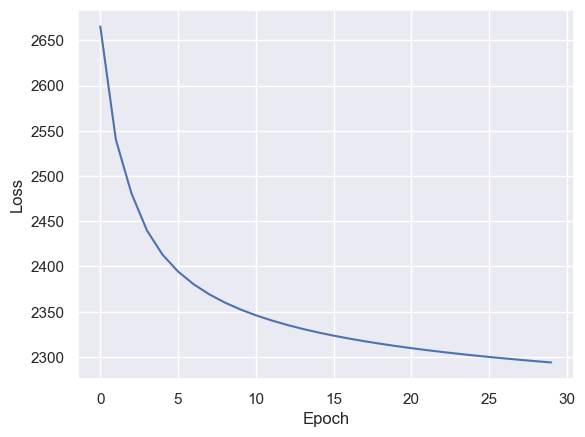

In [7]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss_history)